# Análisis Exploratorio de Datos (EDA)
## Práctica 3 - Clasificación de Hojas de Tomate

**Objetivo**: Entender los datos antes de modelar
- Distribución de clases
- Características de fluorescencia y espectrales
- Correlaciones
- Detección de outliers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Añadir src al path
sys.path.append(str(Path.cwd().parent))
from src.preprocessing import load_data, METADATA_COLS, TARGET_COL, FLUORESCENCE_COLS, get_spectral_columns

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Rutas
DATA_PATH = Path('../data')
print('Directorio de datos:', DATA_PATH.resolve())

Directorio de datos: C:\Users\the_y\OneDrive\Escritorio\UNI\4º\1er cuatrimestre\IN\Practicas\P3\data


## 1. Carga de Datos

In [2]:
# Cargar datos usando la función de preprocessing (limpia valores con espacios)
train_df, test_df = load_data(DATA_PATH / 'train.csv', DATA_PATH / 'test.csv')

print(f'Train: {train_df.shape[0]} muestras, {train_df.shape[1]} columnas')
print(f'Test: {test_df.shape[0]} muestras, {test_df.shape[1]} columnas')
print(f'\nColumnas de train: {list(train_df.columns[:10])}... (+ {len(train_df.columns)-10} más)')

Train: 336 muestras, 309 columnas
Test: 143 muestras, 308 columnas

Columnas de train: ['exp', 'dpi', 'class', 'leaf', 'spot', 'F440', 'F520', 'F680', 'F740', 'w388.13']... (+ 299 más)


In [3]:
# Vista previa
train_df.head()

,exp,dpi,class,leaf,spot,F440,F520,F680,F740,w388.13,...,w1007.98,w1010.23,w1012.48,w1014.74,w1016.99,w1019.25,w1021.5,w1023.76,w1026.02,w1028.28
0,10,1dpi,botrytis,1,1,228.44,415.63,782.43,1504.75,1201,...,7101,7124,7202,7236,7303,7062,7069,7128,7287,7298
1,10,1dpi,botrytis,1,2,232.25,420.37,846.53,1553.05,1665,...,7526,7481,7545,7599,7433,7508,7351,7458,7745,7575
2,10,1dpi,botrytis,1,3,221.46,403.12,822.05,1505.38,730,...,5891,5927,6123,5953,6101,5993,5818,5923,5888,5953
3,10,1dpi,botrytis,1,4,214.32,397.00,851.67,1576.71,745,...,5693,5648,5730,5814,5772,5832,5689,5681,5758,5657
4,10,1dpi,botrytis,2,1,242.70,455.36,586.61,1021.89,1314,...,7496,7529,7543,7590,7611,7639,7645,7446,7576,7556


In [4]:
# Información del dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Columns: 309 entries, exp to w1028.28
dtypes: float64(4), int64(303), object(2)
memory usage: 811.3+ KB


In [5]:
# Estadísticas descriptivas de fluorescencia
train_df[FLUORESCENCE_COLS].describe()

,F440,F520,F680,F740
count,336.000000,336.000000,336.000000,336.000000
mean,235.572173,431.879137,773.102768,1403.550744
std,9.186044,31.660379,120.976092,227.242993
min,209.950000,327.260000,484.270000,795.120000
25%,230.030000,414.195000,690.987500,1236.520000
50%,235.795000,433.160000,765.340000,1405.525000
75%,241.515000,450.987500,844.140000,1538.795000
max,257.330000,517.980000,1270.810000,2125.330000


## 2. Distribución de Clases

Distribución de clases:
class
botrytis    196
control     140
Name: count, dtype: int64

Porcentajes:
class
botrytis    58.333333
control     41.666667
Name: count, dtype: float64


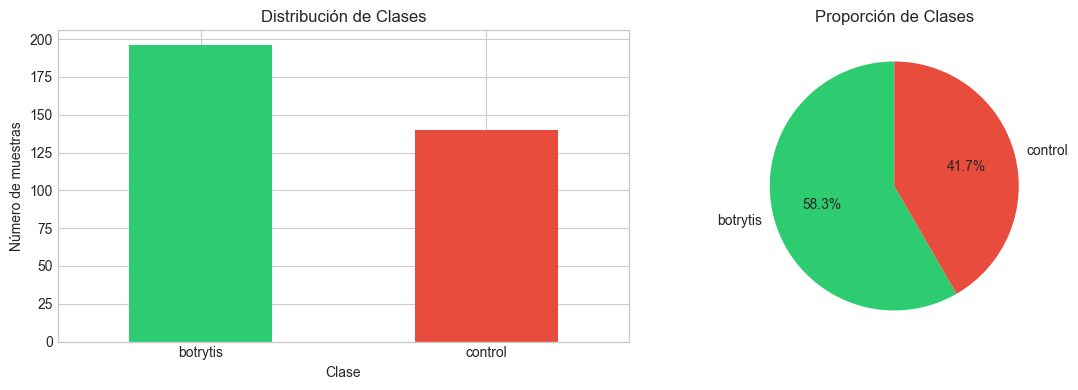


Ratio de desbalance: 1.40:1


In [6]:
# Distribución de clases
class_counts = train_df[TARGET_COL].value_counts()
print('Distribución de clases:')
print(class_counts)
print(f'\nPorcentajes:')
print(class_counts / len(train_df) * 100)

# Visualización
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Barplot
colors = ['#2ecc71', '#e74c3c']
class_counts.plot(kind='bar', ax=ax[0], color=colors)
ax[0].set_title('Distribución de Clases')
ax[0].set_xlabel('Clase')
ax[0].set_ylabel('Número de muestras')
ax[0].tick_params(axis='x', rotation=0)

# Pie chart
ax[1].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax[1].set_title('Proporción de Clases')

plt.tight_layout()
plt.savefig('../docs/distribucion_clases.png', dpi=150, bbox_inches='tight')
plt.show()

# Ratio de desbalance
ratio = class_counts.max() / class_counts.min()
print(f'\nRatio de desbalance: {ratio:.2f}:1')

## 3. Análisis de Variables de Fluorescencia

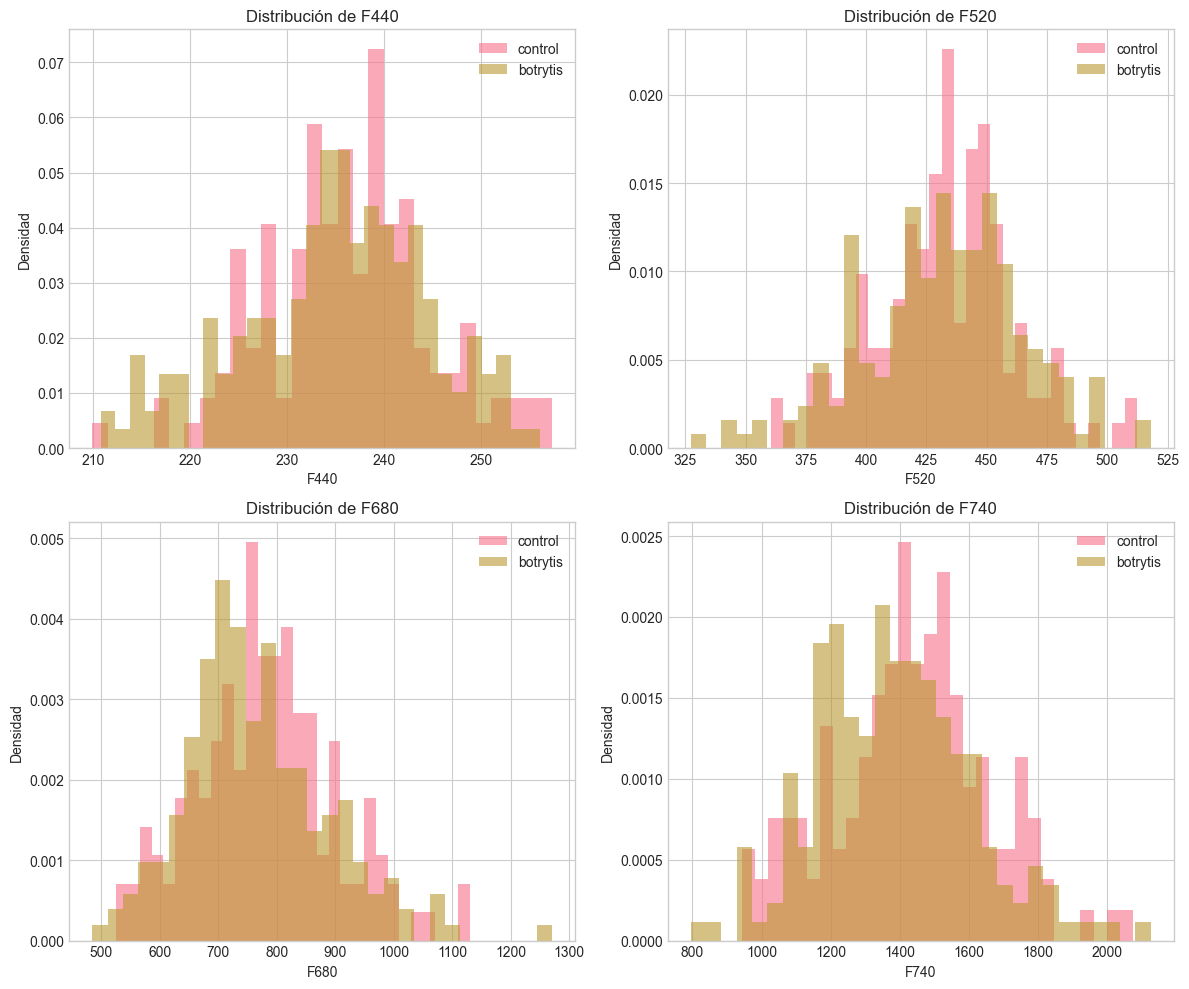

In [7]:
# Distribución de fluorescencia por clase
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, col in enumerate(FLUORESCENCE_COLS):
    ax = axes[idx // 2, idx % 2]
    
    for class_name in ['control', 'botrytis']:
        data = train_df[train_df[TARGET_COL] == class_name][col]
        ax.hist(data, bins=30, alpha=0.6, label=class_name, density=True)
    
    ax.set_title(f'Distribución de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Densidad')
    ax.legend()

plt.tight_layout()
plt.savefig('../docs/fluorescencia_distribucion.png', dpi=150, bbox_inches='tight')
plt.show()

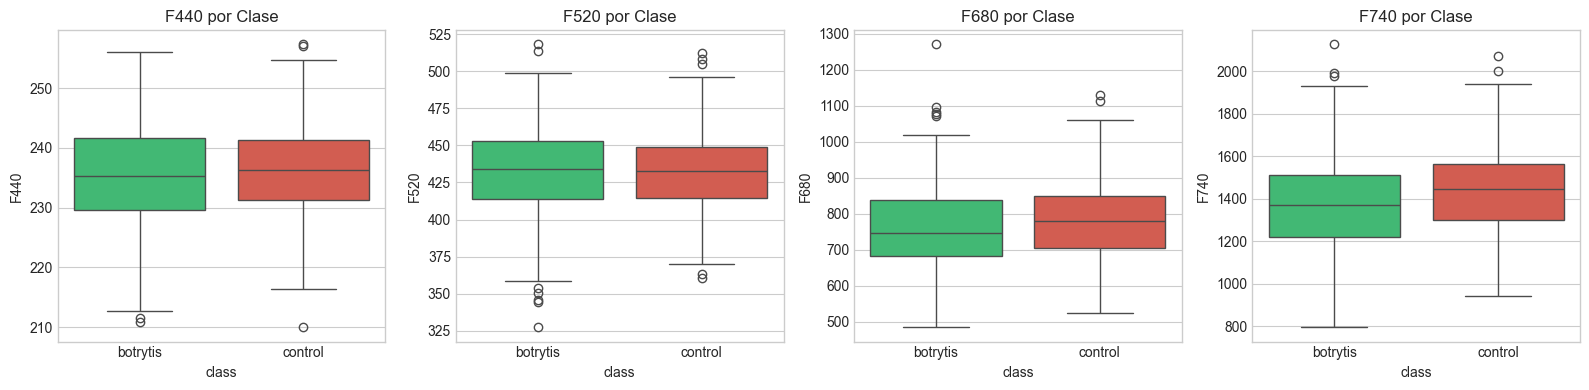

In [8]:
# Boxplots de fluorescencia por clase
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, col in enumerate(FLUORESCENCE_COLS):
    sns.boxplot(data=train_df, x=TARGET_COL, y=col, hue=TARGET_COL, ax=axes[idx], palette=colors, legend=False)
    axes[idx].set_title(f'{col} por Clase')

plt.tight_layout()
plt.savefig('../docs/fluorescencia_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Análisis de Espectros Hiperespectrales

In [9]:
# Obtener columnas espectrales
spectral_cols = get_spectral_columns(train_df)
print(f'Número de variables espectrales: {len(spectral_cols)}')
print(f'Rango: {spectral_cols[0]} a {spectral_cols[-1]}')

# Extraer longitudes de onda numéricas
wavelengths = [float(col[1:]) for col in spectral_cols]
print(f'Longitudes de onda: {wavelengths[0]:.2f} nm a {wavelengths[-1]:.2f} nm')

Número de variables espectrales: 300
Rango: w388.13 a w1028.28
Longitudes de onda: 388.13 nm a 1028.28 nm


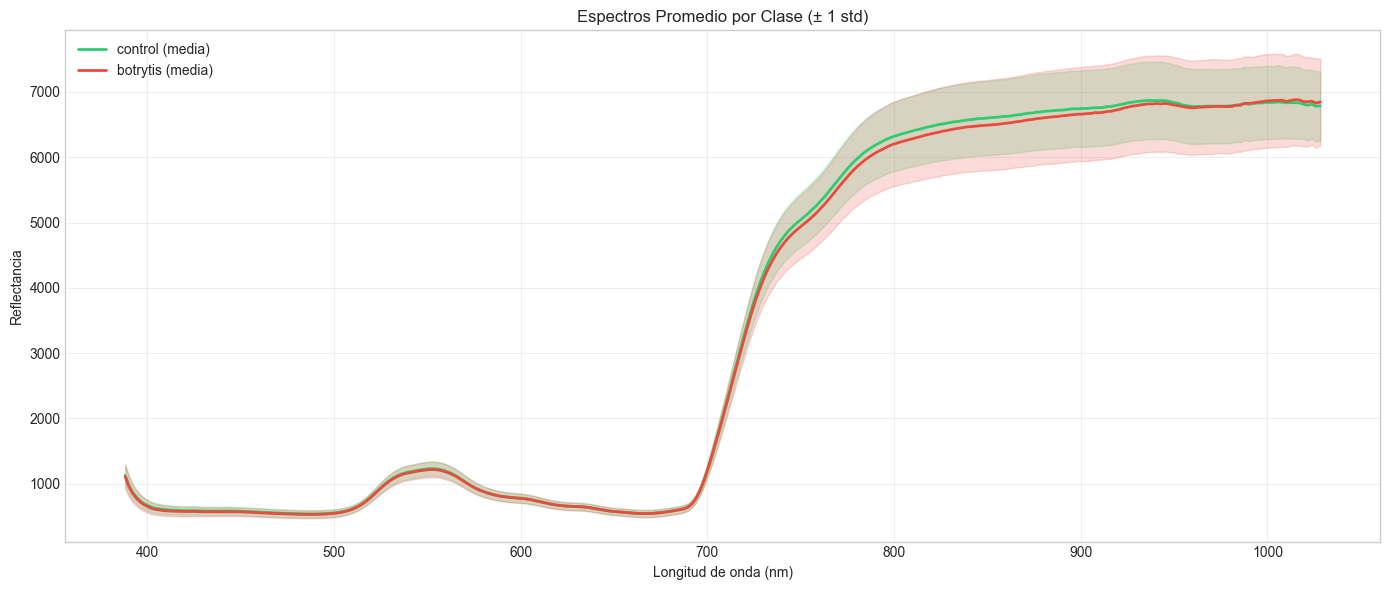

In [10]:
# Espectros promedio por clase
fig, ax = plt.subplots(figsize=(14, 6))

for class_name, color in zip(['control', 'botrytis'], colors):
    class_data = train_df[train_df[TARGET_COL] == class_name][spectral_cols]
    mean_spectrum = class_data.mean()
    std_spectrum = class_data.std()
    
    ax.plot(wavelengths, mean_spectrum, label=f'{class_name} (media)', color=color, linewidth=2)
    ax.fill_between(wavelengths, mean_spectrum - std_spectrum, mean_spectrum + std_spectrum, 
                    alpha=0.2, color=color)

ax.set_xlabel('Longitud de onda (nm)')
ax.set_ylabel('Reflectancia')
ax.set_title('Espectros Promedio por Clase (± 1 std)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/espectros_promedio.png', dpi=150, bbox_inches='tight')
plt.show()

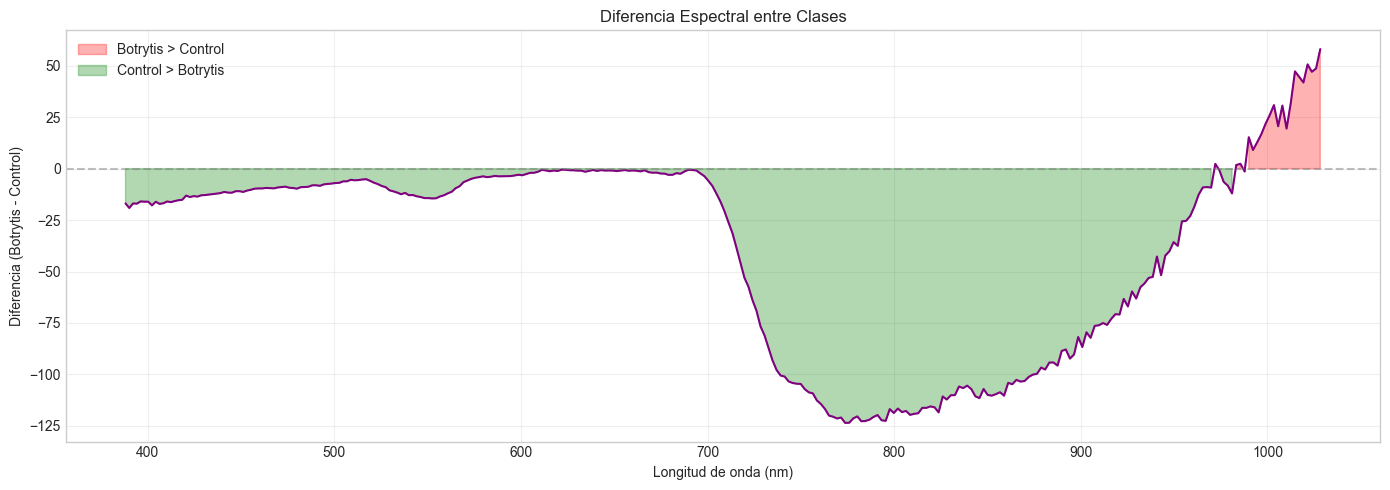

In [11]:
# Diferencia entre espectros
control_mean = train_df[train_df[TARGET_COL] == 'control'][spectral_cols].mean()
botrytis_mean = train_df[train_df[TARGET_COL] == 'botrytis'][spectral_cols].mean()
diff_spectrum = botrytis_mean - control_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(wavelengths, diff_spectrum, color='purple', linewidth=1.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.fill_between(wavelengths, 0, diff_spectrum, where=(diff_spectrum > 0), alpha=0.3, color='red', label='Botrytis > Control')
ax.fill_between(wavelengths, 0, diff_spectrum, where=(diff_spectrum < 0), alpha=0.3, color='green', label='Control > Botrytis')
ax.set_xlabel('Longitud de onda (nm)')
ax.set_ylabel('Diferencia (Botrytis - Control)')
ax.set_title('Diferencia Espectral entre Clases')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/diferencia_espectral.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Correlaciones

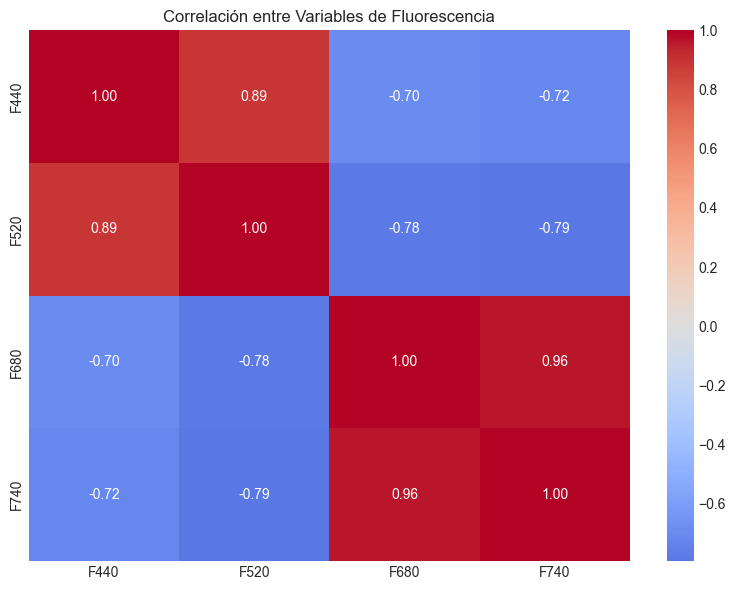

In [12]:
# Correlación entre variables de fluorescencia
fluor_corr = train_df[FLUORESCENCE_COLS].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(fluor_corr, annot=True, cmap='coolwarm', center=0, ax=ax, fmt='.2f')
ax.set_title('Correlación entre Variables de Fluorescencia')

plt.tight_layout()
plt.savefig('../docs/correlacion_fluorescencia.png', dpi=150, bbox_inches='tight')
plt.show()

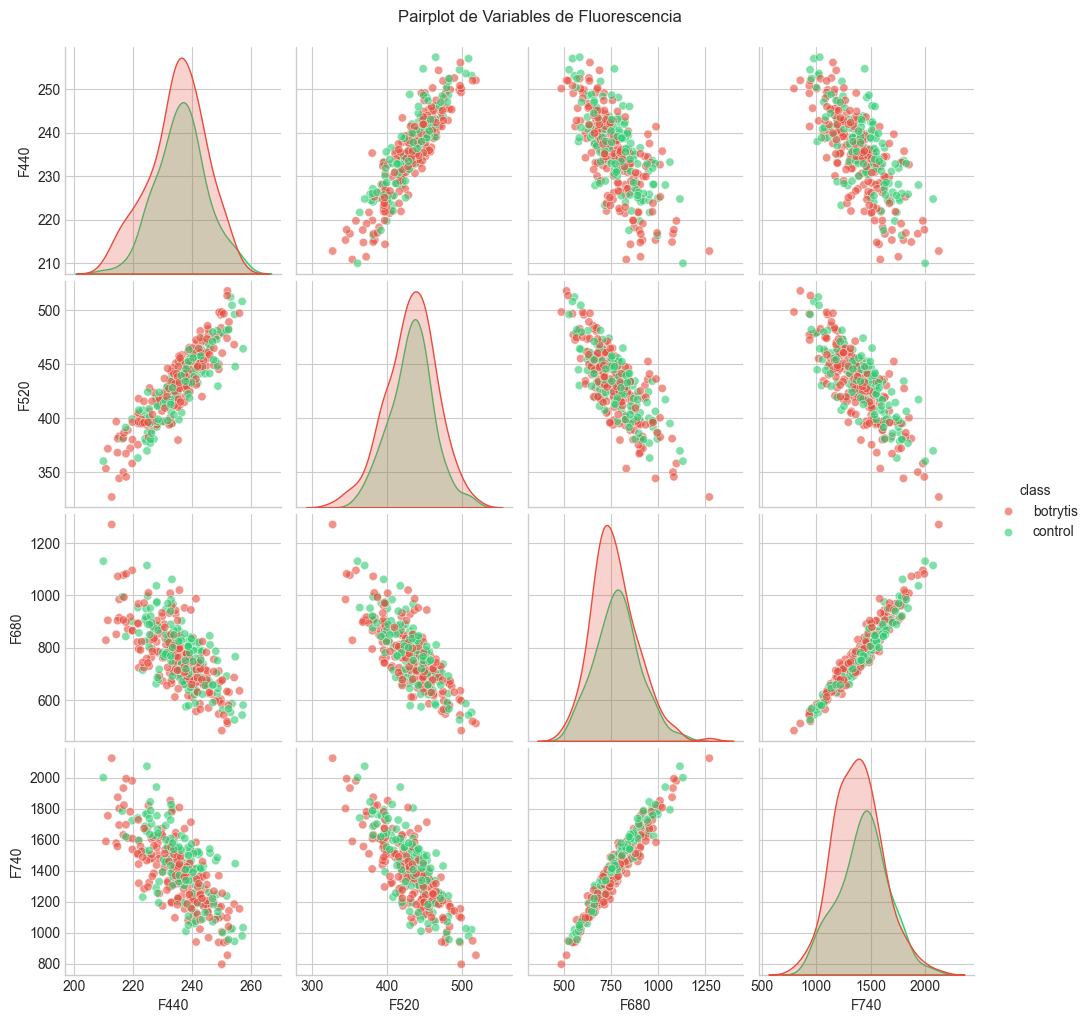

In [13]:
# Pairplot de fluorescencia
g = sns.pairplot(train_df[FLUORESCENCE_COLS + [TARGET_COL]], hue=TARGET_COL, 
                 palette={'control': colors[0], 'botrytis': colors[1]},
                 diag_kind='kde', plot_kws={'alpha': 0.6})
g.fig.suptitle('Pairplot de Variables de Fluorescencia', y=1.02)

plt.savefig('../docs/pairplot_fluorescencia.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Valores Faltantes y Outliers

In [14]:
# Valores faltantes
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df)) * 100

if missing.sum() > 0:
    print('Columnas con valores faltantes:')
    print(missing[missing > 0])
else:
    print('✓ No hay valores faltantes en el dataset de entrenamiento')

# Lo mismo para test
missing_test = test_df.isnull().sum()
if missing_test.sum() > 0:
    print('\nColumnas con valores faltantes en test:')
    print(missing_test[missing_test > 0])
else:
    print('✓ No hay valores faltantes en el dataset de test')

✓ No hay valores faltantes en el dataset de entrenamiento
✓ No hay valores faltantes en el dataset de test


In [15]:
# Detección de outliers con IQR en fluorescencia
def count_outliers_iqr(df, columns):
    outlier_counts = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_counts[col] = outliers
    return outlier_counts

outliers = count_outliers_iqr(train_df, FLUORESCENCE_COLS)
print('Outliers detectados (método IQR) en fluorescencia:')
for col, count in outliers.items():
    print(f'  {col}: {count} ({count/len(train_df)*100:.1f}%)')

Outliers detectados (método IQR) en fluorescencia:
  F440: 4 (1.2%)
  F520: 10 (3.0%)
  F680: 6 (1.8%)
  F740: 4 (1.2%)


## 7. Reducción de Dimensionalidad (PCA Exploratorio)

Componentes para 95% varianza: 3
Componentes para 99% varianza: 7


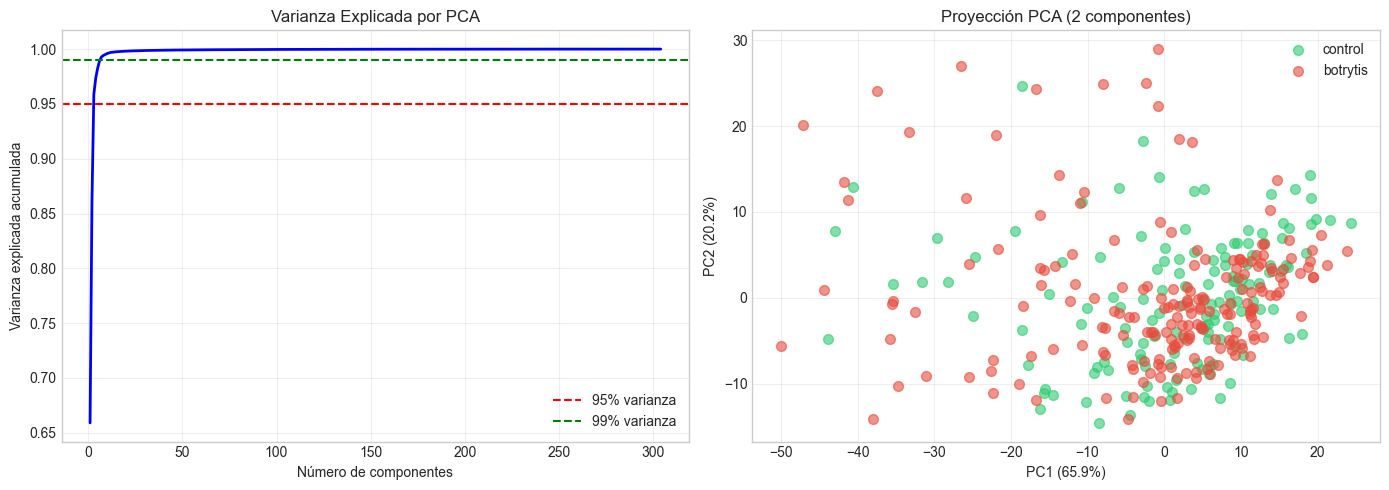

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Preparar datos (solo features válidas)
feature_cols = FLUORESCENCE_COLS + spectral_cols
X = train_df[feature_cols].values
y = train_df[TARGET_COL].values

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Varianza explicada acumulada
axes[0].plot(range(1, len(cumsum_var) + 1), cumsum_var, 'b-', linewidth=2)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
axes[0].axhline(y=0.99, color='g', linestyle='--', label='99% varianza')
axes[0].set_xlabel('Número de componentes')
axes[0].set_ylabel('Varianza explicada acumulada')
axes[0].set_title('Varianza Explicada por PCA')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Encontrar número de componentes para 95% y 99%
n_95 = np.argmax(cumsum_var >= 0.95) + 1
n_99 = np.argmax(cumsum_var >= 0.99) + 1
print(f'Componentes para 95% varianza: {n_95}')
print(f'Componentes para 99% varianza: {n_99}')

# Proyección en 2D
for class_name, color in zip(['control', 'botrytis'], colors):
    mask = y == class_name
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, label=class_name, alpha=0.6, s=50)

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('Proyección PCA (2 componentes)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/pca_exploratorio.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Resumen de Hallazgos

### Conclusiones del EDA:

1. **Distribución de clases**: Dataset ligeramente desbalanceado con ratio 1.40:1 (196 botrytis / 140 control, 58.3% vs 41.7%). El desbalance es moderado y no debería requerir técnicas agresivas de balanceo.

2. **Variables de fluorescencia**: 
   - F440 y F520 muestran correlación positiva fuerte (0.89)
   - F680 y F740 están altamente correlacionadas (0.96)
   - Existe correlación negativa entre el grupo (F440, F520) y (F680, F740), sugiriendo dos grupos de características complementarias
   - Outliers moderados: F440 (1.2%), F520 (3.0%), F680 (1.8%), F740 (1.2%)

3. **Espectros hiperespectrales**: 
   - 300 variables espectrales en rango 388-1028 nm
   - Las diferencias entre clases son sutiles pero consistentes a lo largo del espectro
   - Mayor diferencia en regiones específicas del espectro (visible en gráfico de diferencias)

4. **Correlaciones**: Alta multicolinealidad entre variables espectrales adyacentes (esperado en datos hiperespectrales). Las variables de fluorescencia forman dos grupos correlacionados.

5. **Valores faltantes**: No hay valores faltantes en train ni test. Dataset limpio.

6. **PCA**: 
   - Solo 3 componentes explican 95% de la varianza
   - 7 componentes explican 99% de la varianza
   - Alta reducibilidad dimensional (de 304 a 3-7 componentes)
   - En proyección 2D hay solapamiento entre clases, indicando que la separación no es trivial

### Recomendaciones para modelado:

- **Reducción de dimensionalidad**: Aplicar PCA (3-7 componentes) o SelectKBest para reducir multicolinealidad
- **Escalado**: Usar StandardScaler dado el rango diferente entre fluorescencia y espectros
- **Modelos sugeridos**: Empezar con Logistic Regression y Random Forest como baselines, luego probar SVM y Gradient Boosting
- **Validación**: Usar StratifiedKFold (5-10 folds) para mantener proporción de clases
- **Métrica**: F1-score como métrica principal (requerido por la competición)
- **Balanceo**: Considerar class_weight='balanced' en modelos que lo soporten, aunque el desbalance es leve